In [1]:
import os

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from tifffile import imread

from skimage.color import gray2rgb
from skimage import img_as_float

In [2]:
tissue = 'WD-76845-097'

In [3]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [4]:
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/over-segmentation'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# read unfiltered single-cell data
data = pd.read_parquet('/Volumes/My Book/cylinter_input/sardana-097/output/checkpoints/aggregateData.parquet')

# crop
ymin = 10440
ymax = 10590
xmin = 1995
xmax = 2145

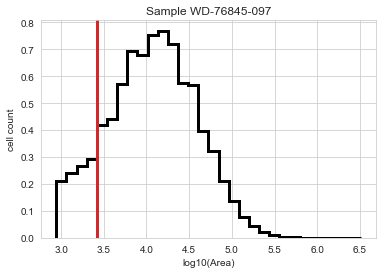

In [5]:
# read DNA1 image of selected tissue and crop to target size
dna = imread(
    '/Volumes/My Book/cylinter_input/sardana-097/' +
    f'tif/{tissue}.ome.tif', key=0
    )
dna_crop = dna[ymin:ymax, xmin:xmax]

# read segmentation outlines for target tissue sample and crop ROI
seg = imread(
    '/Volumes/My Book/cylinter_input/sardana-097/' +
    f'seg/{tissue}.ome.tif', key=0
    )
seg_crop = seg[ymin:ymax, xmin:xmax]

# plot histogram
gate = (0, 3.42)
sns.set_style('whitegrid')
plt.hist(np.log(data['Area']), bins=30, color='k', density=True, histtype='step', lw=3.0) 
plt.axvline(gate[1], c='tab:red', lw=3.0)
plt.title(f'Sample {tissue}')
plt.xlabel('log10(Area)')
plt.ylabel('cell count')
plt.savefig(os.path.join(save_dir, 'gated_hist.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


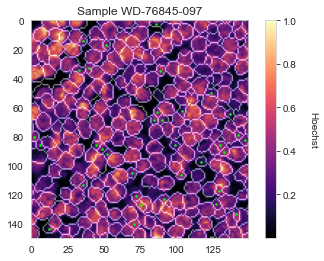

In [6]:
# plot cropped image window
blank = np.zeros((dna_crop.shape[0], dna_crop.shape[1]))
blank = gray2rgb(blank)

dna_crop = img_as_float(dna_crop)
dna_crop = np.clip(dna_crop, 0.05, 0.8)
dna_crop = (dna_crop - np.min(dna_crop))/np.ptp(dna_crop)

dna_crop_rgb = plt.cm.magma(dna_crop) # converts to RGBA automatically
dna_crop_rgb = dna_crop_rgb[:, :, 0:3]  # drop alpha dimension

# dna_crop_rgb = gray2rgb(dna_crop)
# dna_crop_rgb *= (0.5, 0.5, 0.5)
dna_crop_rgb *= 0.9
blank += dna_crop_rgb

seg_crop = img_as_float(seg_crop)
seg_crop_rgb = gray2rgb(seg_crop)
seg_crop_rgb *= 0.5
blank += seg_crop_rgb

plt.imshow(blank, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('Hoechst', labelpad=20, rotation=270)
cbar.draw_all()

data_crop = data[['Y_centroid', 'X_centroid', 'Area']][
    (data['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (data['Y_centroid'].between(ymin, ymax, inclusive='both')) &
    (np.log(data['Area']).between(gate[0], gate[1], inclusive='both'))
    ]

data_crop['X_centroid'] = data_crop['X_centroid']-xmin
data_crop['Y_centroid'] = data_crop['Y_centroid']-ymin

plt.scatter(
    data_crop['X_centroid'],
    data_crop['Y_centroid'], s=6.5, lw=0.0, color='lime'
    )

plt.title(f'Sample {tissue}')
plt.savefig(os.path.join(save_dir, 'sardana.png'), dpi=1000)

# save as a pdf, too
plt.savefig(os.path.join(save_dir, 'sardana.pdf'))
plt.show()
plt.close('all')